In [1]:
# Standard imports
import os

# 3rd-party imports
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from huggingface_hub import hf_hub_download
from PIL import Image

# Local imports

c:\Users\chun\Desktop\Projects\uv_CV_Segmentation_viaSegformer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# VIdeo link - https://www.youtube.com/watch?v=lSp5p281er0

vid_filepath = '../data/Tokyo.mp4'
extract_filepath = None

def extract_img():
    vid = cv2.VideoCapture(vid_filepath)  
    
    ret, frame = vid.read()
    if ret:
        img_extract = os.path.basename(vid_filepath).rsplit('.', 1)[0] + '.jpg'
        extract_filepath = os.path.join('../data', img_extract)
        
        os.makedirs(os.path.dirname(extract_filepath), exist_ok=True)
        cv2.imwrite(extract_filepath, frame)
    
    vid.release()

extract_img()

## Load model & Image processor

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
processor = SegformerImageProcessor(do_resize=True, size={"height": 1000, "width": 1000})
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

## ADE20K palette

In [4]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values. From googhe sheets:
    https://docs.google.com/spreadsheets/d/1se8YEtb2detS7OuPE86fXGyD269pMycAWe2mtKUj2W8/edit?gid=0#gid=0"""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

### Methods

In [5]:
import requests
from io import BytesIO

def process_image(image_path, alpha:float=0.5) -> tuple[Image.Image, Image.Image]:
    """
    Load image from local directory / URL / PIL Image instance.
    Relay to semantic segmentation.

    Args:
        image_path (str or PIL.Image): Path to an image file, URL, or a PIL Image instance.
        alpha (float, optional): Opacity of mask. 0 = Transparent; 1 = Opaque.

    Raises:
        ValueError: Error Message.

    Returns:
        tuple[Image.Image, Image.Image]: 
            - First image: Original image
            - Second image: Original image + Predicted Segmentation Mask
    """
    # Load image
    if isinstance(image_path, str):
        if image_path.startswith(('http://', 'https://')):
            resp = requests.get(image_path)
            img = Image.open(BytesIO(resp.content)).convert("RGB")
        else:
            img = Image.open(image_path).convert("RGB")
    elif isinstance(image_path, Image.Image):
        img = image_path.convert("RGB")
    else:
        raise ValueError("Unsupported input type. Provide a file path, URL, or PIL.Image.")

    return img, segment_image(image=img, alpha=0.5)

def segment_image(image:Image.Image, alpha:float=0.5) -> Image.Image:
    """
    Performs semantic segmentation on an image and returns an overlay mask.

    Args:
        image (Image.Image): Image
        alpha (float, optional): Opacity of mask. 0 = Transparent; 1 = Opaque.

    Returns:
        Image.Image: Original image blended with the segmentation mask.
    """
    # Preprocess and forward pass
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = model(pixel_values)

    # Post-process to get mask
    seg_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0].cpu().numpy()
    seg_mask = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)

    # Create color mask
    palette = np.array(ade_palette(), dtype=np.uint8)
    for label, color in enumerate(palette):
        seg_mask[seg_map == label] = color

    # Overlay segmentation mask atop original image
    img = np.array(image)
    img_seg = (img * (1 - alpha) + seg_mask * alpha).astype(np.uint8)

    return Image.fromarray(img_seg)

def groundtruth_image(image: Image.Image, segmentation_map: Image.Image, alpha: float = 0.5) -> Image.Image:
    """
    Shows the ground truth segmentation on image. It is meant for ADE20K dataset.

    Args:
        image (Image.Image): Original image
        segmentation_map (Image.Image): Ground truth segmentation.
        alpha (float, optional): Opacity of mask. 0 = Transparent; 1 = Opaque.

    Returns:
        Image.Image: Original image blended with ground truth segmentation.
    """
    # Post-process to get mask
    seg_map = np.array(segmentation_map)  # 2D ground truth segmentation map
    seg_mask = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)

    # Create color mask
    palette = np.array(ade_palette(), dtype=np.uint8)
    for label, color in enumerate(palette):
        seg_mask[seg_map -1 == label, :] = color

    # Overlay segmentation mask atop original image
    img = np.array(image)
    img_seg = (img * (1 - alpha) + seg_mask * alpha).astype(np.uint8)
    return Image.fromarray(img_seg)


def from_ade20k(file_name: str) -> tuple[Image.Image, Image.Image, Image.Image]:
    """
    Downloads an image and its ground truth segmentation map from ADE20K,
    then returns both the predicted segmentation and ground truth overlays.

    Args:
        file_name (str): Name of the file (without extension) in the dataset.

    Returns:
        tuple[Image.Image, Image.Image]: 
            - First image: Original image
            - Second image: Original image + Predicted Segmentation Mask
            - Third image: Original image + Ground Truth Mask
    """
    # Download and load image + ground truth
    repo_id = "hf-internal-testing/fixtures_ade20k"
    img_path = hf_hub_download(repo_id=repo_id, filename=f"{file_name}.jpg", repo_type="dataset", local_dir="../data")
    segmentation_map_path = hf_hub_download(repo_id=repo_id, filename=f"{file_name}.png", repo_type="dataset", local_dir="../data")
    img = Image.open(img_path)
    seg_map = Image.open(segmentation_map_path)

    return img, segment_image(image=img), groundtruth_image(image=img, segmentation_map=seg_map)  # Return both images

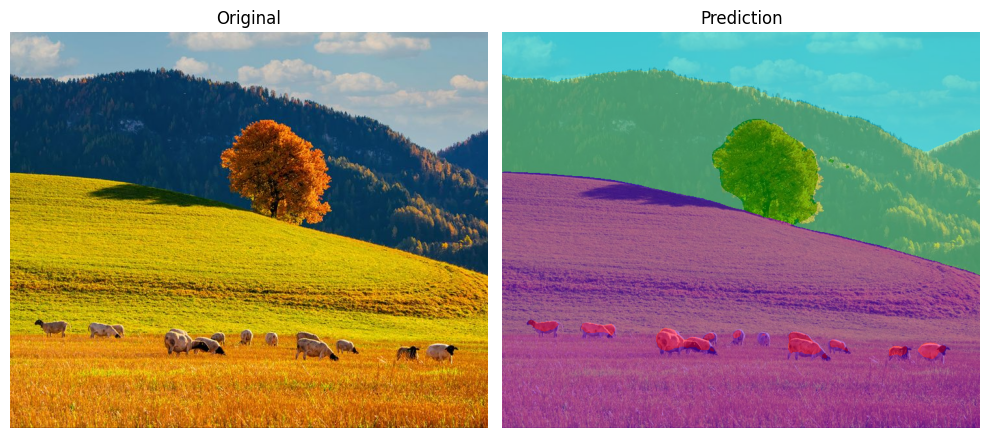

In [6]:
# Example usage:
img, img_seg = process_image("https://i.pinimg.com/736x/17/e7/fc/17e7fc299466b2afd989e709fe7c9815.jpg")

fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(img)
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(img_seg)
axs[1].set_title("Prediction")
axs[1].axis('off')

plt.tight_layout()
plt.show()

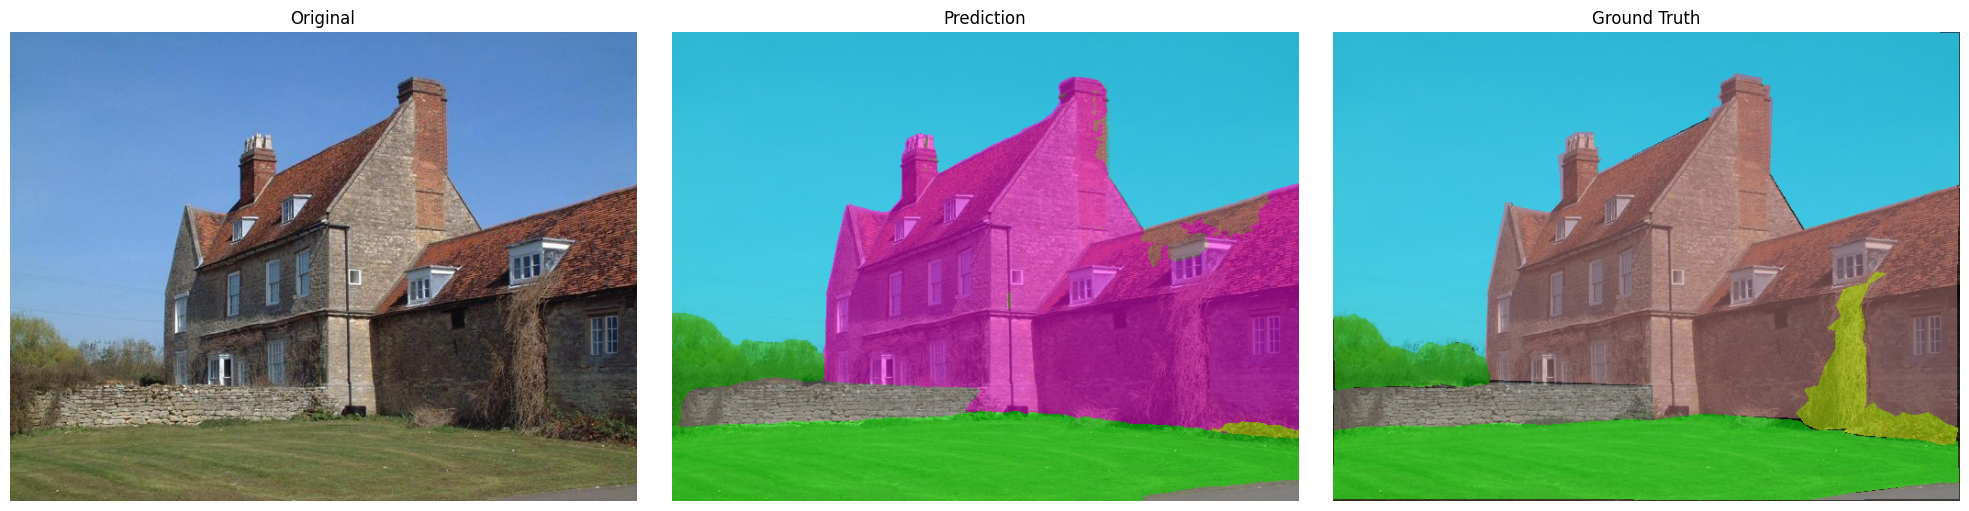

In [7]:
# Example usage
img, img_seg, img_gt = from_ade20k("ADE_val_00000001")

fig, axs = plt.subplots(1, 3, figsize=(20,5))

axs[0].imshow(img)
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(img_seg)
axs[1].set_title("Prediction")
axs[1].axis('off')

axs[2].imshow(img_gt)
axs[2].set_title("Ground Truth")
axs[2].axis('off')

plt.tight_layout()
plt.show()

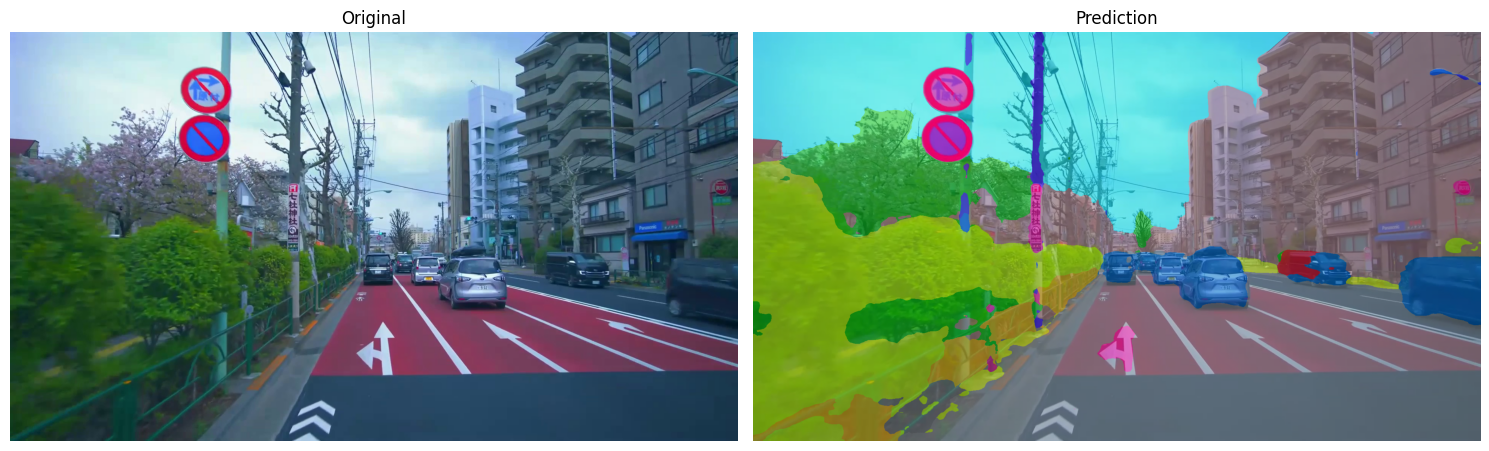

In [8]:
img, img_seg = process_image('../data/Tokyo.jpg')

fig, axs = plt.subplots(1, 2, figsize=(15,10))

axs[0].imshow(img)
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(img_seg)
axs[1].set_title("Prediction")
axs[1].axis('off')

plt.tight_layout()
plt.show()